In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score,train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

from patsy import dmatrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [72]:
df = pd.read_csv('/content/drive/MyDrive/An introduction to statistical analysis/data/College.csv')
df = df.iloc[:, 1:]
df = df.rename(columns = {'F.Undergrad': 'FUndergrad', 'P.Undergrad': 'PUndergrad',
                          'Room.Board': 'RoomBoard', 'S.F.Ratio': 'SFRatio', 'perc.alumni':'PercAlumni',
                          'Grad.Rate':'GradRate'})
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,FUndergrad,PUndergrad,Outstate,RoomBoard,Books,Personal,PhD,Terminal,SFRatio,PercAlumni,Expend,GradRate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Private     777 non-null    object 
 1   Apps        777 non-null    int64  
 2   Accept      777 non-null    int64  
 3   Enroll      777 non-null    int64  
 4   Top10perc   777 non-null    int64  
 5   Top25perc   777 non-null    int64  
 6   FUndergrad  777 non-null    int64  
 7   PUndergrad  777 non-null    int64  
 8   Outstate    777 non-null    int64  
 9   RoomBoard   777 non-null    int64  
 10  Books       777 non-null    int64  
 11  Personal    777 non-null    int64  
 12  PhD         777 non-null    int64  
 13  Terminal    777 non-null    int64  
 14  SFRatio     777 non-null    float64
 15  PercAlumni  777 non-null    int64  
 16  Expend      777 non-null    int64  
 17  GradRate    777 non-null    int64  
dtypes: float64(1), int64(16), object(1)
memory usage: 109.4+ KB


<Axes: >

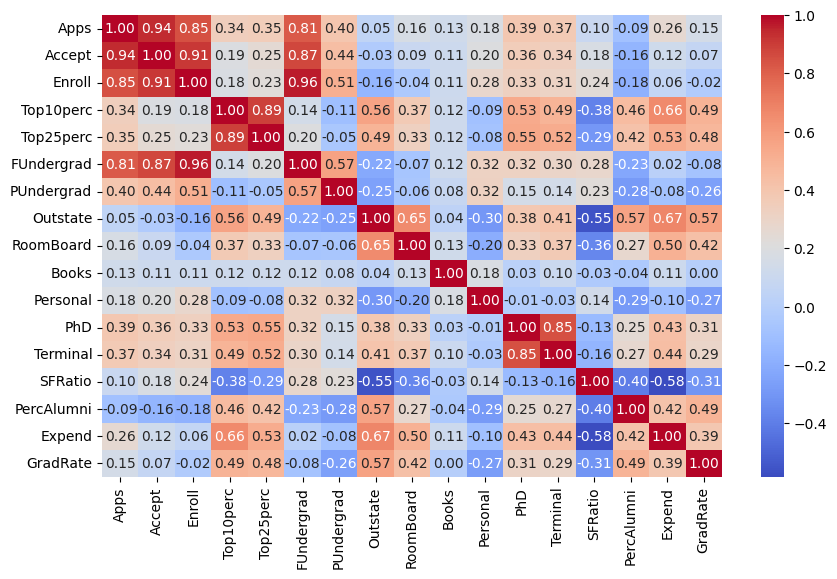

In [76]:
plt.figure(figsize =(10,6))
sns.heatmap(df.drop(['Private'], axis = 1).corr(), annot = True, fmt = '2.2f', cmap = 'coolwarm')

In [85]:
df['Private'] = (df['Private'] == 'Yes').astype(int)
X = df.drop(['Outstate', 'Accept'], axis = 1)
y = df['Outstate']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2025)
print(f'The shape of train is: {X_train.shape}')
print(f'The shape of test is: {X_test.shape}')

The shape of train is: (582, 16)
The shape of test is: (195, 16)


The best feature was Expend, and now R-squared is: 0.4629
The best feature was RoomBoard, and now R-squared is: 0.5915
The best feature was PercAlumni, and now R-squared is: 0.6812
The best feature was GradRate, and now R-squared is: 0.6984
The best feature was FUndergrad, and now R-squared is: 0.7144
The best feature was Terminal, and now R-squared is: 0.7254


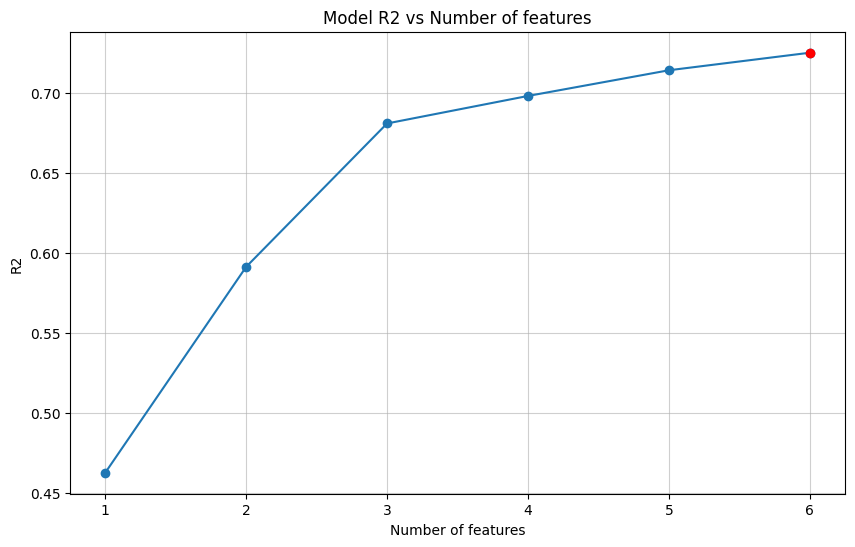

In [87]:
def forward_selection(X, y, threshold=0.005):
    features_selected = []
    remaining_features = list(X.columns)
    best_r2 = 0
    best_model = None
    r2_vals = []
    while remaining_features:
        r2_candidates = []

        for feature in remaining_features:
            X_temp = sm.add_constant(X[features_selected + [feature]])
            model = sm.OLS(y, X_temp).fit()
            r2_candidates.append((model.rsquared, feature, model))


        r2_candidates.sort(reverse = True, key = lambda x: x[0])
        new_best, best_feature, new_best_model = r2_candidates[0]

        if new_best - best_r2 > threshold:
            features_selected.append(best_feature)
            remaining_features.remove(best_feature)
            best_r2 = new_best
            best_model = new_best_model
            r2_vals.append(new_best)
            print(f'The best feature was {best_feature}, and now R-squared is: {best_r2:.4f}')
        else:
            break
    max_score_index = np.argmax(r2_vals) + 1
    max_score = max(r2_vals)
    len_fe = len(r2_vals) + 1
    plt.figure(figsize = (10,6))
    plt.plot(range(1, len_fe), r2_vals, marker = 'o')
    plt.plot(max_score_index, max_score, marker = 'o', color = 'red')
    plt.title('Model R2 vs Number of features')
    plt.xlabel('Number of features')
    plt.ylabel('R2')
    plt.xticks(ticks=(range(1, len_fe)))
    plt.grid(alpha = 0.6)
    plt.show()

    return features_selected, best_model



selected_vars, model = forward_selection(X_train, y_train)

In [88]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Outstate   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     253.1
Date:                Thu, 30 Jan 2025   Prob (F-statistic):          9.62e-158
Time:                        16:19:53   Log-Likelihood:                -5291.2
No. Observations:                 582   AIC:                         1.060e+04
Df Residuals:                     575   BIC:                         1.063e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3067.4699    588.013     -5.217      0.0

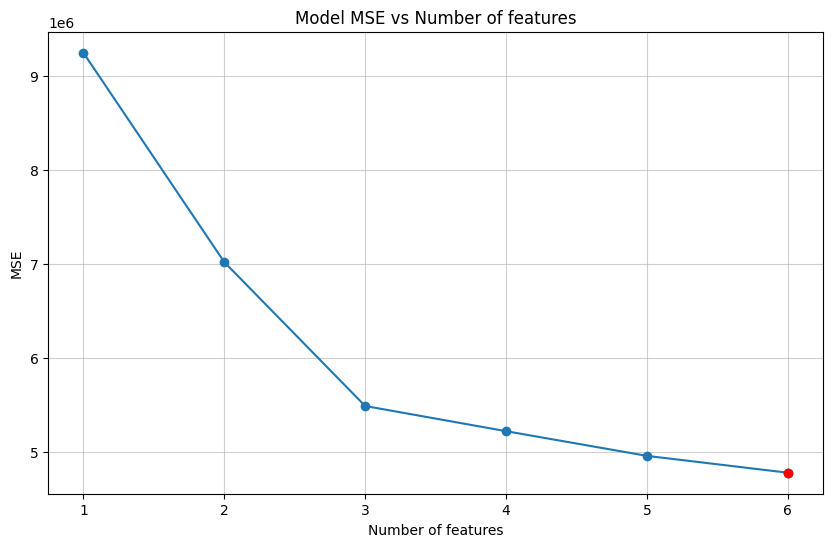

In [89]:
validation_scores = {}
features = []
lr = LinearRegression()
for i, feature in enumerate(selected_vars):
    features.append(feature)
    X_temp = X_train[features]
    model = lr.fit(X_temp, y_train)
    validation_scores[i + 1] = (-np.mean(cross_val_score(model, X_temp, y_train, scoring = 'neg_mean_squared_error', cv = 10)))

min_degree = min(validation_scores, key = validation_scores.get)
min_mse = validation_scores[min_degree]
plt.figure(figsize = (10,6))
plt.plot(range(1, len(selected_vars) + 1), validation_scores.values(), marker = 'o')
plt.plot(min_degree, min_mse, marker = 'o', color = 'red')
plt.title('Model MSE vs Number of features')
plt.xlabel('Number of features')
plt.ylabel('MSE')
plt.xticks(ticks=range(1, len(selected_vars) + 1))
plt.grid(alpha = 0.6)
plt.show()


# Applying Polynomial Regression with N degrees to the best features

In [90]:
power = 10
best_degrees = {}
for feature in selected_vars:
    score_dict = {}
    for degree in range(3, power + 1):
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X_train[feature].to_frame())
        lr = LinearRegression()
        mse = (-np.mean(cross_val_score(lr, X_poly, y_train, scoring = 'neg_mean_squared_error', cv = 10)))
        score_dict[degree] = mse

    degree_best = min(score_dict, key = score_dict.get)
    best_degrees[feature] = degree_best
    print(f'For the {feature} the best degree is: {degree_best}')

For the Expend the best degree is: 3
For the RoomBoard the best degree is: 4
For the PercAlumni the best degree is: 3
For the GradRate the best degree is: 3
For the FUndergrad the best degree is: 4
For the Terminal the best degree is: 3


In [91]:
formula = ' + '.join([f'cr({feature}, df={d})' for feature, d in zip(selected_vars, best_degrees.values())])

# Verifica que la fórmula se genera correctamente
print("Fórmula generada:", formula)

# Crear la matriz de diseño con las transformaciones especificadas
X_transf = dmatrix(formula, data=X_train[selected_vars], return_type='dataframe')

# Ajustar el modelo
model = sm.OLS(y_train, X_transf).fit()

# Mostrar el resumen del modelo
print(model.summary())

Fórmula generada: cr(Expend, df=3) + cr(RoomBoard, df=4) + cr(PercAlumni, df=3) + cr(GradRate, df=3) + cr(FUndergrad, df=4) + cr(Terminal, df=3)
                            OLS Regression Results                            
Dep. Variable:               Outstate   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     150.8
Date:                Thu, 30 Jan 2025   Prob (F-statistic):          1.36e-180
Time:                        16:20:00   Log-Likelihood:                -5215.5
No. Observations:                 582   AIC:                         1.046e+04
Df Residuals:                     567   BIC:                         1.053e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|

# Evaluation on test set

In [92]:
X_transf_test = dmatrix(formula, data = X_test, return_type = 'dataframe')
model_preds = model.predict(X_transf_test)

mse = mean_squared_error(y_test, model_preds)
r2 = r2_score(y_test, model_preds)

print(f'The variance explain is: {r2} and the MSE IS: {mse:.4f}')

The variance explain is: 0.6862222677568358 and the MSE IS: 4411402.8194


Theres clearly been a decent chunk of overfitting in our train data.
Try using simpler models to trade variance by adding bias.

In [93]:
best_degrees

{'Expend': 3,
 'RoomBoard': 4,
 'PercAlumni': 3,
 'GradRate': 3,
 'FUndergrad': 4,
 'Terminal': 3}

This are the variables responsible of non linearity of our model.